In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
import seaborn as sns




In [368]:
df = pd.read_csv("StudentPerformanceFactors.csv")
df.head(5)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [370]:
df.describe()


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [371]:
df.columns[df.isnull().any()]



Index(['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home'], dtype='object')

In [372]:
categorical_columns=[col for col in df.columns if df[col].dtype=='object']
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
numerical_cloumns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]


In [373]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) else 0

def fill_missing_with_rf(df, target_col, n=5):
    df_copy = df.copy()

    # Split numerical and categorical features
    numeric_features = df_copy.select_dtypes(include=['int64', 'float64']).columns.drop(target_col, errors='ignore')
    cat_features = df_copy.select_dtypes(include=['object', 'category']).columns.drop(target_col, errors='ignore')

    # Filter rows without null in target for training
    df_train = df_copy[df_copy[target_col].notna()]
    
    # 1. ANOVA F-test for numeric features
    f_vals = {}
    for col in numeric_features:
        if df_train[col].isna().sum() == 0:
            f_val = f_classif(df_train[[col]], df_train[target_col])[0][0]
            f_vals[col] = round(f_val, 4)
    
    # 2. Cramér's V for categorical features
    cramers_v_vals = {}
    for col in cat_features:
        if df_train[col].isna().sum() == 0:
            try:
                cramers_v_vals[col] = round(cramers_v(df_train[col], df_train[target_col]), 4)
            except:
                cramers_v_vals[col] = 0.0

    # Sort and select top n features
    sorted_numeric = sorted(f_vals.items(), key=lambda x: x[1], reverse=True)[:n]
    sorted_categorical = sorted(cramers_v_vals.items(), key=lambda x: x[1], reverse=True)[:n]

    best_features = [f[0] for f in (sorted_numeric + sorted_categorical)[:n]]

    # Show important features
    print(f"🧪 Numerical Features vs {target_col} (ANOVA F-values):")
    for k, v in sorted_numeric:
        print(f"{k:<25}: {v}")
    print("\n🔁 Categorical Features vs {target_col} (Cramér's V):")
    for k, v in sorted_categorical:
        print(f"{k:<25}: {v}")

    # Prepare data for modeling
    model_df = df_copy[best_features + [target_col]].dropna()
 

    X_train = model_df[best_features]
    y_train = model_df[target_col]

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # Prepare test data (rows with null target but not null features)
    predict_df = df_copy[df_copy[target_col].isna() & df_copy[best_features].notna().all(axis=1)].copy()

    if predict_df.empty:
        print(f"\n⚠️ No rows available to predict for '{target_col}' (maybe nulls in the features?)")
        return df_copy

  

    # Predict and fill
    df_copy.loc[predict_df.index, target_col] = clf.predict(predict_df[best_features])
    print(f"✅ Filled {len(predict_df)} missing values in '{target_col}' using RandomForest\n.")
    print("-------------------------------------------------------------------\n")
    return df_copy


In [374]:

df = fill_missing_with_rf(df, target_col='Distance_from_Home', n=2)
df = fill_missing_with_rf(df, target_col='Teacher_Quality', n=2)
df = fill_missing_with_rf(df, target_col='Parental_Education_Level', n=2)

🧪 Numerical Features vs Distance_from_Home (ANOVA F-values):
Exam_Score               : 27.3593
Attendance               : 1.3536

🔁 Categorical Features vs {target_col} (Cramér's V):
Extracurricular_Activities: 0.0256
Family_Income            : 0.0189
✅ Filled 67 missing values in 'Distance_from_Home' using RandomForest
.
-------------------------------------------------------------------

🧪 Numerical Features vs Teacher_Quality (ANOVA F-values):
Exam_Score               : 19.6394
Previous_Scores          : 3.1915

🔁 Categorical Features vs {target_col} (Cramér's V):
Motivation_Level         : 0.0314
Extracurricular_Activities: 0.0212
✅ Filled 78 missing values in 'Teacher_Quality' using RandomForest
.
-------------------------------------------------------------------

🧪 Numerical Features vs Parental_Education_Level (ANOVA F-values):
Exam_Score               : 36.4272
Physical_Activity        : 3.3053

🔁 Categorical Features vs {target_col} (Cramér's V):
School_Type              : 0

In [375]:
df.columns[df.isnull().any()]

Index([], dtype='object')

Text(0.5, 1.0, 'Correlation Between Numerical Features')

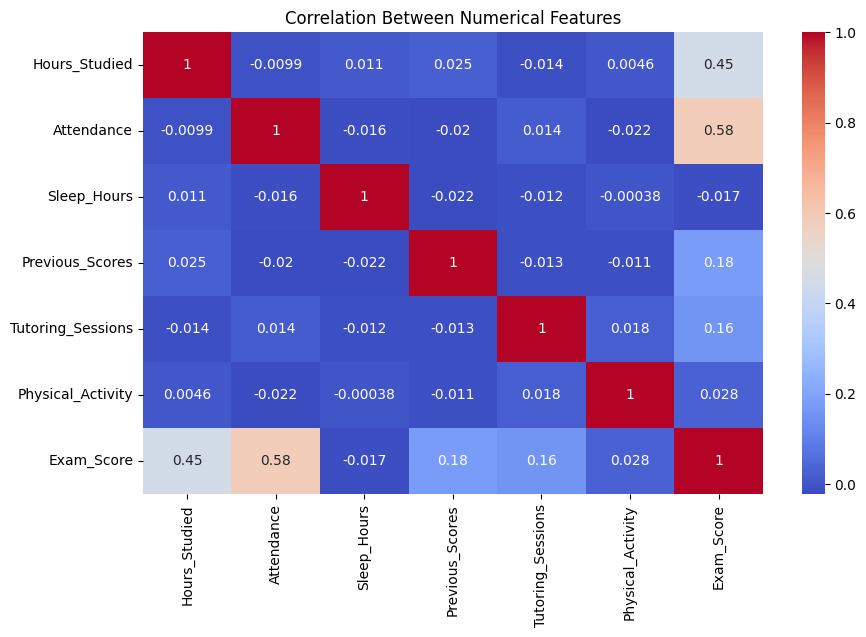

In [376]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")


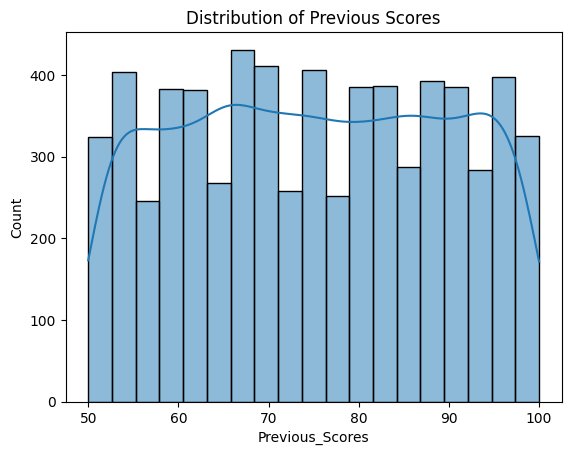

In [377]:
sns.histplot(df['Previous_Scores'], kde=True)
plt.title('Distribution of Previous Scores')
plt.show()

Text(0.5, 1.0, 'Distribution of Exam Scores')

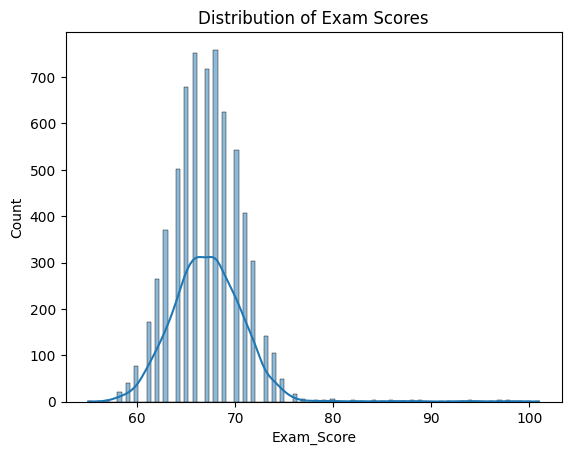

In [378]:
sns.histplot(df['Exam_Score'], kde=True)
plt.title("Distribution of Exam Scores")


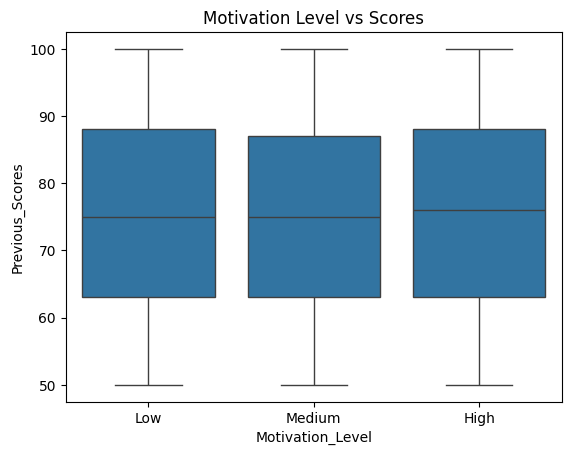

In [379]:
sns.boxplot(x='Motivation_Level', y='Previous_Scores', data=df)
plt.title('Motivation Level vs Scores')
plt.show()

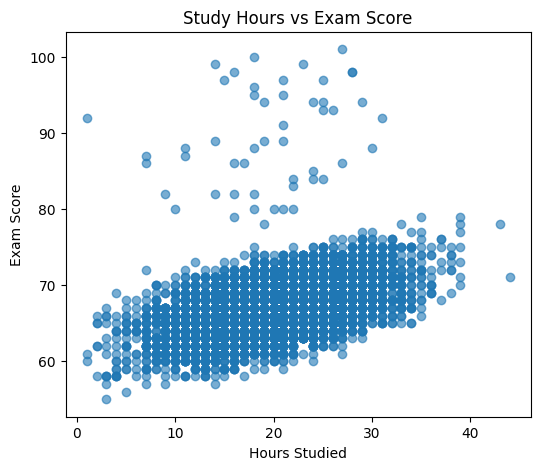

In [380]:
# Assuming you still have the original unscaled values
plt.figure(figsize=(6, 5))
plt.scatter(df['Hours_Studied'], df['Exam_Score'], alpha=0.6)
plt.title('Study Hours vs Exam Score')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.show()


In [381]:
scaler = StandardScaler()
df['Hours_Studied'] = scaler.fit_transform(df[['Hours_Studied']])
df['Attendance'] = scaler.fit_transform(df[['Attendance']])


In [382]:
# 1. Encode ordinal columns (Low, Medium, High)
ordinal_cols = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 
                'Family_Income', 'Teacher_Quality']

# Make sure values are strings
df[ordinal_cols] = df[ordinal_cols].astype(str)

# Define a single encoder for all columns
encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']] * len(ordinal_cols))


# Fit and transform only on clean (original) values
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols]).astype(int)

# 2. Encode binary Yes/No
binary_map = {'No': 0, 'Yes': 1}
df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(binary_map)
df['Internet_Access'] = df['Internet_Access'].map(binary_map)
df['Learning_Disabilities'] = df['Learning_Disabilities'].map(binary_map)

# 3. Scale numerical column
scaler = StandardScaler()
df['Previous_Scores'] = scaler.fit_transform(df[['Previous_Scores']])

# 4. Encode School_Type
df['School_Type'] = df['School_Type'].map({'Public': 0, 'Private': 1})

# 5. Encode Peer_Influence
df['Peer_Influence'] = df['Peer_Influence'].astype(str)
peer_encoder = OrdinalEncoder(categories=[['Negative', 'Neutral', 'Positive']])
df['Peer_Influence'] = peer_encoder.fit_transform(df[['Peer_Influence']]).astype(int)

# 6. Encode Parental_Education_Level
df['Parental_Education_Level'] = df['Parental_Education_Level'].astype(str)
edu_encoder = OrdinalEncoder(categories=[['High School', 'College', 'Postgraduate']])
df['Parental_Education_Level'] = edu_encoder.fit_transform(df[['Parental_Education_Level']]).astype(int)

# 7. Encode Distance_from_Home
df['Distance_from_Home'] = df['Distance_from_Home'].astype(str)
dist_encoder = OrdinalEncoder(categories=[['Near', 'Moderate', 'Far']])
df['Distance_from_Home'] = dist_encoder.fit_transform(df[['Distance_from_Home']]).astype(int)

# 8. Encode Gender
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})


In [383]:
# 1. Define features and target
X = df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('reg', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best polynomial degree:", grid.best_params_['poly__degree'])
print("Best CV score (MSE):", -grid.best_score_)

# === Model 1: Linear Regression 
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

y_train_pred_linear = model_linear.predict(X_train)
y_test_pred_linear = model_linear.predict(X_test)

train_mse_linear = mean_squared_error(y_train, y_train_pred_linear)
test_mse_linear = mean_squared_error(y_test, y_test_pred_linear)

train_r2_linear = model_linear.score(X_train, y_train)
test_r2_linear = model_linear.score(X_test, y_test)

# === Model 2: Polynomial Regression 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

y_train_pred_poly = model_poly.predict(X_train_poly)
y_test_pred_poly = model_poly.predict(X_test_poly)

train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)

train_r2_poly = model_poly.score(X_train_poly, y_train)
test_r2_poly = model_poly.score(X_test_poly, y_test)

# === Print Results ===
print("=== Linear Regression  ===")
print(f"Training MSE: {train_mse_linear:.2f}")
print(f"Test MSE: {test_mse_linear:.2f}")
print(f"Train R² Score: {train_r2_linear:.4f}")
print(f"Test R² Score: {test_r2_linear:.4f}\n")

print("=== Polynomial Regression  ===")
print(f"Training MSE: {train_mse_poly:.2f}")
print(f"Test MSE: {test_mse_poly:.2f}")
print(f"Train R² Score: {train_r2_poly:.4f}")
print(f"Test R² Score: {test_r2_poly:.4f}")


Best polynomial degree: 1
Best CV score (MSE): 4.388810539440275
=== Linear Regression  ===
Training MSE: 4.35
Test MSE: 2.89
Train R² Score: 0.7152
Test R² Score: 0.7985

=== Polynomial Regression  ===
Training MSE: 4.19
Test MSE: 3.01
Train R² Score: 0.7259
Test R² Score: 0.7900


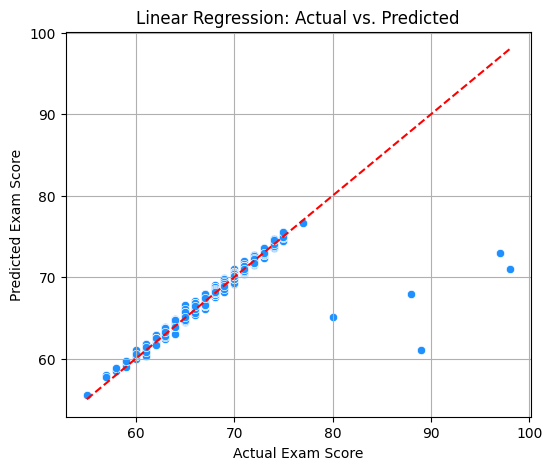

In [386]:
# Linear Regression
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_test_pred_linear, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Linear Regression: Actual vs. Predicted")
plt.grid(True)
plt.show()

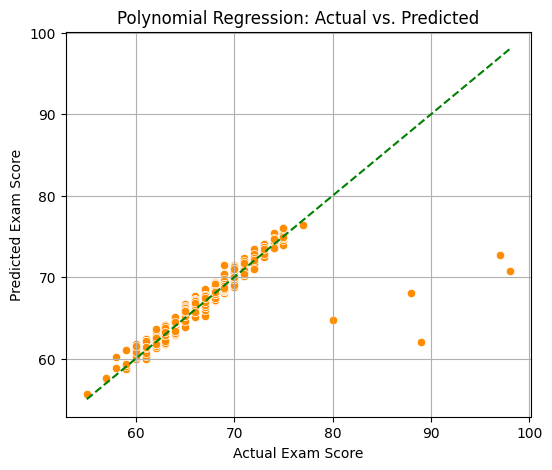

In [387]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_test_pred_poly, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='green')
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Polynomial Regression: Actual vs. Predicted")
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Actual vs Predicted Exam Scores')

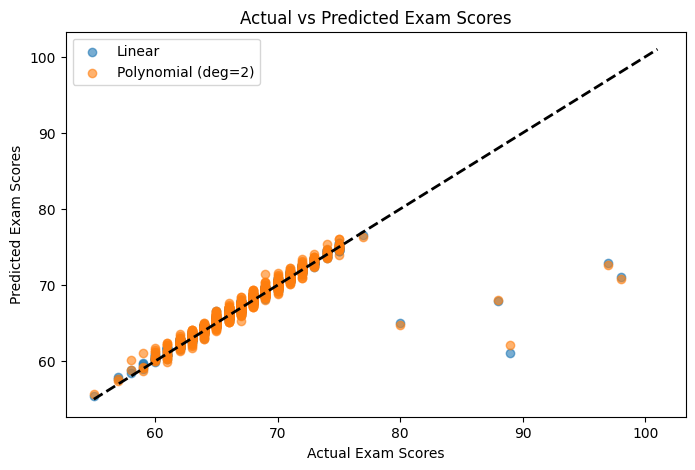

In [389]:

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test_pred_linear, label="Linear", alpha=0.6)
plt.scatter(y_test, y_test_pred_poly, label="Polynomial (deg=2)", alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Exam Scores")
plt.ylabel("Predicted Exam Scores")
plt.legend()
plt.title("Actual vs Predicted Exam Scores")



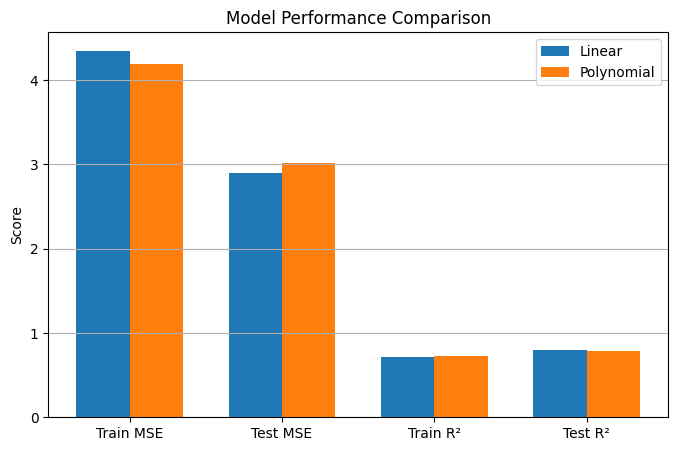

In [391]:

metrics = ['Train MSE', 'Test MSE', 'Train R²', 'Test R²']
linear_scores = [train_mse_linear, test_mse_linear, train_r2_linear, test_r2_linear]
poly_scores = [train_mse_poly, test_mse_poly, train_r2_poly, test_r2_poly]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, linear_scores, width, label='Linear')
plt.bar(x + width/2, poly_scores, width, label='Polynomial')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(True, axis='y')
plt.show()
